In [72]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams['lines.linewidth'] = 0.2

from struct import *

import serial
import numpy as np

import experiments

PROTO_END_OF_TRANSFER = b'\x0a'
PROTO_CMD_INITIALIZE = b'\x01'
PROTO_CMD_ENCRYPT = b'\x02'
PROTO_CMD_FINALIZE = b'\x03'

sm = experiments.ScopeManager()

In [2]:
class Arduino:
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        self.is_connected = False
        self.serial = None

    def connect(self):
        if not self.is_connected:
            self.serial = serial.Serial(*self.args, **self.kwargs)
            self.is_connected = True
            self.serial.read(1)
            self.serial.read(1)

    def close(self):
        if self.is_connected:
            self.is_connected = False
            self.serial.close()

    def initialize(self, plain_text, key):
        if not self.is_connected:
            raise Exception('ConnectionError')

        self.serial.write(
            pack('c16s16sc', PROTO_CMD_INITIALIZE, plain_text, key, PROTO_END_OF_TRANSFER)
        )

        return self.serial.read(1)

    def encrypt(self):
        if not self.is_connected:
            raise Exception('ConnectionError')

        self.serial.write(
            pack('cc', PROTO_CMD_ENCRYPT, PROTO_END_OF_TRANSFER)
        )

    def wait_encrypt_end(self):
        return self.serial.read(1)

    def finalize(self):
        if not self.is_connected:
            raise Exception('ConnectionError')

        self.serial.write(
            pack('cc', PROTO_CMD_FINALIZE, PROTO_END_OF_TRANSFER)
        )

        result = self.serial.read(16)
        return result

In [3]:
plain = b'abcd' * 4
key = b'\x00' * 16

aud = Arduino(port='COM3', timeout=3)

In [20]:
aud.connect()

for x in range(4):
    aud.initialize(bytes([x] * 16), key)
    aud.encrypt()
    aud.wait_encrypt_end()
    result = aud.finalize()
    print(result)

aud.close()


b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
b'\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01'
b'\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02'
b'\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03\x03'


CH1 : CH1

CH2 : CH2

CH1 : CH1

CH2 : CH2

CH1 : CH1

CH2 : CH2

CH1 : CH1

CH2 : CH2

CH1 : CH1

CH2 : CH2

CH1 : CH1

CH2 : CH2



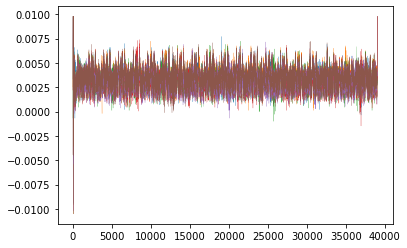

In [44]:


main_trace = []

aud.connect()

for x in range(3):
    for _ in range(2):
        aud.initialize(plain, bytes([x]*16))
        aud.encrypt()
        (main_volt, main_time), (trigger_volt, trigger_time) = sm.get_data(['CH1', 'CH2'])
        aud.wait_encrypt_end()
        result = aud.finalize()
        main_trace.append(main_volt[trigger_volt > 0.3])

aud.close()

for i, trace in enumerate(main_trace):
    plt.plot(trace, label=f'trace{i}')
# plt.plot(trigger_volt, label='trigger')
plt.show()

(0,)


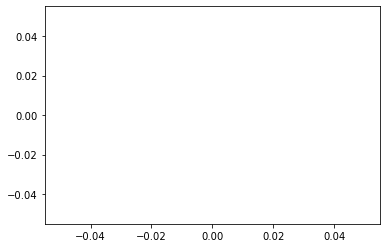

In [11]:

# sample = main_volt * (trigger_volt > 3.04)
sample = main_volt[trigger_volt > 3.04]
print(sample.shape)
plt.plot(sample)
plt.show()

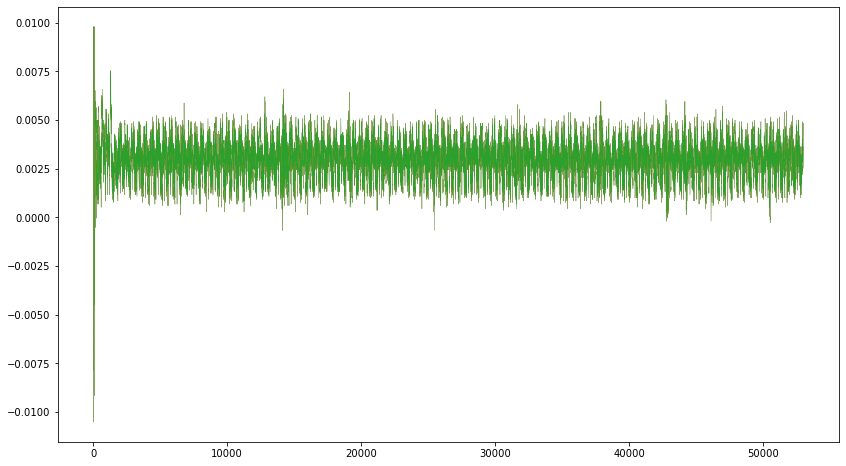

In [12]:

for i, trace in enumerate(main_trace):
    plt.plot(trace, label=f'trace{i}')
plt.show()

In [18]:
trigger_volt.max()

0.00644

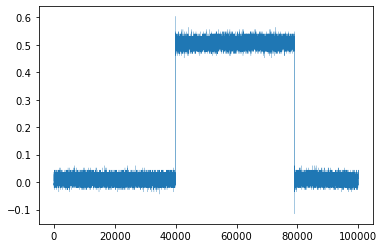

In [24]:

plt.plot(trigger_volt)

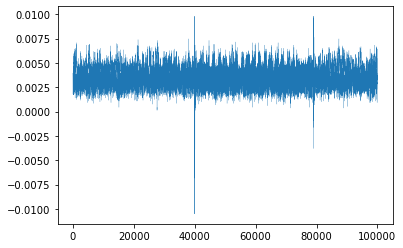

In [25]:
plt.plot(main_volt)

In [6]:
np.sum(main_volt - trigger_volt)

-27111.361119999998

[[1.         0.92451323]
 [0.92451323 1.        ]]
0.0006048797119721867


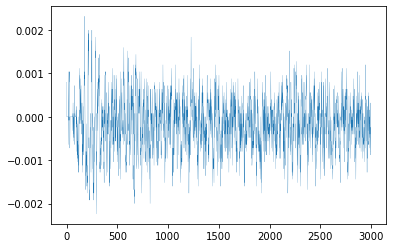

In [48]:
x, y = main_trace[0], main_trace[1]
x = x[:3000]
y = y[:3000]
print(np.corrcoef(x, y))
print(np.std(x-y))
plt.plot(x-y)

[[1.         0.91056881]
 [0.91056881 1.        ]]
0.0006634165275802727


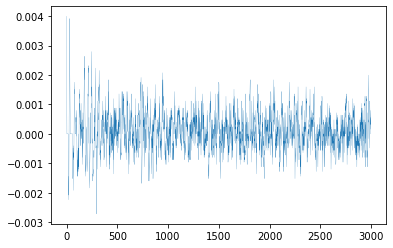

In [49]:
x, y = main_trace[0], main_trace[2]
x = x[:3000]
y = y[:3000]
print(np.corrcoef(x, y))
print(np.std(x-y))
plt.plot(x-y)

[[1.         0.92951749]
 [0.92951749 1.        ]]
0.000595146458165271


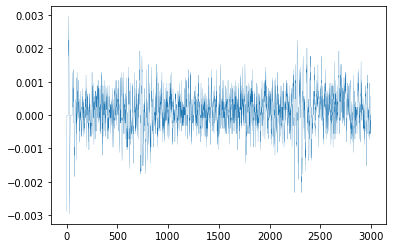

In [50]:
x, y = main_trace[2], main_trace[3]
x = x[:3000]
y = y[:3000]
print(np.corrcoef(x, y))
print(np.std(x-y))
plt.plot(x-y)

[[1.         0.90311683]
 [0.90311683 1.        ]]
0.0006992497902434835


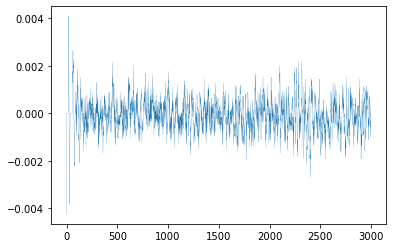

In [51]:
x, y = main_trace[3], main_trace[4]
x = x[:3000]
y = y[:3000]
print(np.corrcoef(x, y))
print(np.std(x-y))
plt.plot(x-y)

In [67]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(x, height=0.004)

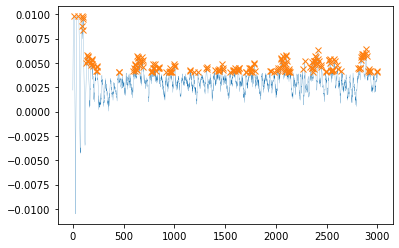

In [68]:
plt.plot(x)
plt.plot(peaks, x[peaks], 'x')

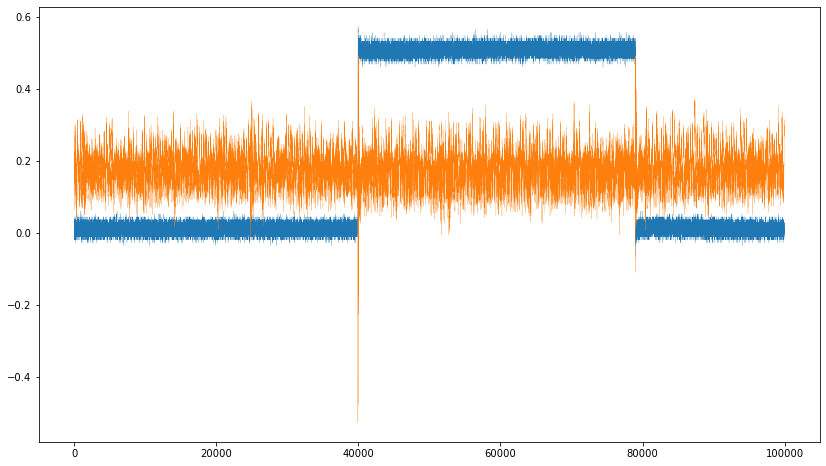

In [73]:
plt.plot(trigger_volt)
plt.plot(main_volt * 50)

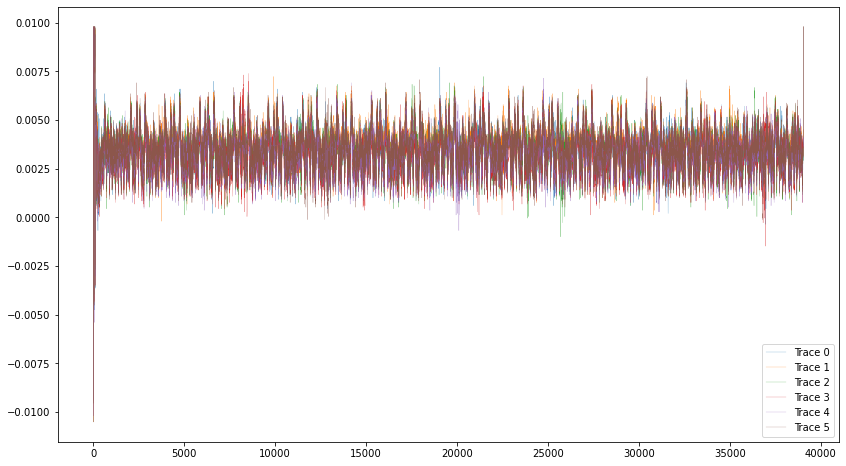

In [83]:
# x = main_trace[0]
#peaks, _ = find_peaks(x, height=0.0058)

# plt.plot(peaks, x[peaks], 'x')

for i, x in enumerate(main_trace):
    plt.plot(x, label=f'Trace {i}')

plt.legend()